In [1]:
from IPython.display import clear_output

In [2]:
!pip install nltk
!pip install pycocoevalcap
clear_output(wait=False)

In [3]:
import numpy as np 
import pandas as pd 
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation 
from tensorflow.keras.layers import concatenate, BatchNormalization, Input
from tensorflow.keras.layers import Add 
from tensorflow.keras.utils import to_categorical, plot_model 
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input 
import matplotlib.pyplot as plt
import cv2 
import string

In [4]:
test_images_file = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt'
train_images_file = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'

In [5]:
text_folder = '/kaggle/input/flickr8k-dataset/Flickr8k_text'

if os.path.exists(text_folder):
    available_files = os.listdir(text_folder)
else:
    available_files = "Text folder not found."

In [6]:
def load_description(text): 
	mapping = dict() 
	for line in text.split("\n"): 
		token = line.split("\t") 
		if len(line) < 2: # remove short descriptions 
			continue
		img_id = token[0].split('.')[0] # name of the image 
		img_des = token[1]			 # description of the image 
		if img_id not in mapping: 
			mapping[img_id] = list() 
		mapping[img_id].append(img_des) 
	return mapping 

token_path = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read() 
descriptions = load_description(text) 
print(descriptions['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [7]:
def clean_description(desc): 
	for key, des_list in desc.items(): 
		for i in range(len(des_list)): 
			caption = des_list[i] 
			caption = [ch for ch in caption if ch not in string.punctuation] 
			caption = ''.join(caption) 
			caption = caption.split(' ') 
			caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()] 
			caption = ' '.join(caption) 
			des_list[i] = caption 

clean_description(descriptions) 
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [8]:
def to_vocab(desc): 
	words = set() 
	for key in desc.keys(): 
		for line in desc[key]: 
			words.update(line.split()) 
	return words 
vocab = to_vocab(descriptions)

In [9]:
import glob 
images = '/kaggle/input/flickr8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset'
# Create a list of all image names in the directory 
img = glob.glob(images + '*.jpg') 

train_path = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n") 
train_img = [] # list of all images in training set 
for im in img: 
	if(im[len(images):] in train_images): 
		train_img.append(im) 
		
# load descriptions of training set in a dictionary. Name of the image will act as ey 
def load_clean_descriptions(des, dataset): 
	dataset_des = dict() 
	for key, des_list in des.items(): 
		if key+'.jpg' in dataset: 
			if key not in dataset_des: 
				dataset_des[key] = list() 
			for line in des_list: 
				desc = 'startseq ' + line + ' endseq'
				dataset_des[key].append(desc) 
	return dataset_des 

train_descriptions = load_clean_descriptions(descriptions, train_images) 
print(train_descriptions['1000268201_693b08cb0e'])


['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [10]:
from keras.preprocessing.image import load_img, img_to_array 
def preprocess_img(img_path): 
	# inception v3 excepts img in 299 * 299 * 3 
	img = load_img(img_path, target_size = (299, 299)) 
	x = img_to_array(img) 
	# Add one more dimension 
	x = np.expand_dims(x, axis = 0) 
	x = preprocess_input(x) 
	return x 

def encode(image): 
	image = preprocess_img(image) 
	vec = model.predict(image) 
	vec = np.reshape(vec, (vec.shape[1])) 
	return vec 

base_model = InceptionV3(weights = 'imagenet') 
model = Model(base_model.input, base_model.layers[-2].output) 
# run the encode function on all train images and store the feature vectors in a list 
encoding_train = {} 
for img in train_img: 
	encoding_train[img[len(images):]] = encode(img) 


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
# list of all training captions 
all_train_captions = [] 
for key, val in train_descriptions.items(): 
	for caption in val: 
		all_train_captions.append(caption) 

# consider only words which occur atleast 10 times 
vocabulary = vocab 
threshold = 10 # you can change this value according to your need 
word_counts = {} 
for cap in all_train_captions: 
	for word in cap.split(' '): 
		word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold] 

# word mapping to integers 
ixtoword = {} 
wordtoix = {} 

ix = 1
for word in vocab: 
	wordtoix[word] = ix 
	ixtoword[ix] = word 
	ix += 1
	
# find the maximum length of a description in a dataset 
max_length = max(len(des.split()) for des in all_train_captions) 
max_length


34

In [12]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Initialize the Xception model without the classification layer
model = Xception(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features
def extract_features(directory):
    features = {}
    for img_name in os.listdir(directory):
        # Construct full file path
        filename = os.path.join(directory, img_name)
        
        # Load and preprocess the image
        image = load_img(filename, target_size=(299, 299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        
        # Extract features
        feature = model.predict(image, verbose=0)
        img_id = img_name.split('.')[0]  # Remove file extension
        features[img_id] = feature[0]
        
    return features

# Path to the Flickr8k images folder
image_directory = '/kaggle/input/flickr8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset'
train_features = extract_features(image_directory)

# Save extracted features
np.save('train_features.npy', train_features)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


I0000 00:00:1738987659.148132      98 service.cc:145] XLA service 0x7e142c001a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738987659.148201      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1738987661.850909      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
print(list(train_features.keys())[:5])  # Check the first few keys

In [14]:
# Load pre-extracted features
train_features = np.load('/kaggle/working/train_features.npy', allow_pickle=True).item()

# Define vocab_size based on the length of wordtoix
vocab_size = len(wordtoix) + 1  # Add 1 to account for padding index
X1, X2, y = list(), list(), list() 
for key, des_list in train_descriptions.items(): 
	pic = train_features[key] 
	for cap in des_list: 
		seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix] 
		for i in range(1, len(seq)): 
			in_seq, out_seq = seq[:i], seq[i] 
			in_seq = pad_sequences([in_seq], maxlen = max_length)[0] 
			out_seq = to_categorical([out_seq], num_classes = vocab_size)[0] 
			# store 
			X1.append(pic) 
			X2.append(in_seq) 
			y.append(out_seq) 

X2 = np.array(X2) 
X1 = np.array(X1) 
y = np.array(y) 

# load glove vectors for embedding layer 
embeddings_index = {} 
golve_path ='/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
glove = open(golve_path, 'r', encoding = 'utf-8').read() 
for line in glove.split("\n"): 
	values = line.split(" ") 
	word = values[0] 
	indices = np.asarray(values[1: ], dtype = 'float32') 
	embeddings_index[word] = indices 

emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim)) 
for word, i in wordtoix.items(): 
	emb_vec = embeddings_index.get(word) 
	if emb_vec is not None: 
		emb_matrix[i] = emb_vec 
emb_matrix.shape

(1652, 200)

In [15]:
from tensorflow.keras.layers import Add, BatchNormalization, Bidirectional, Dense, LSTM, Dropout, Embedding, Input

# Define the model
ip1 = Input(shape=(2048,))
fe1 = Dropout(0.3)(ip1)
fe2 = Dense(512, activation='relu')(fe1)  # Keep 512 size
fe2 = BatchNormalization()(fe2)

ip2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, emb_dim)(ip2)  # Removed mask_zero=True
se2 = Dropout(0.3)(se1)
se3 = Bidirectional(LSTM(512, return_sequences=False, recurrent_activation="sigmoid"))(se2)

# Fix the shape mismatch
se3 = Dense(512, activation='relu')(se3)  # Reduce 1024 → 512

# Merge
decoder1 = Add()([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
decoder2 = BatchNormalization()(decoder2)

outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Create the model
model = Model(inputs=[ip1, ip2], outputs=outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 200)   │    330,400 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 200)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1024)      │  2,920,448 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 512)       │          0 │ batch_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1652)      │    847,476 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,938,964 (22.66 MB)

 Trainable params: 5,936,916 (22.65 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(learning_rate=1e-4)
model.layers[2].set_weights([emb_matrix]) 
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer) 
model.fit([X1, X2], y, epochs = 100, batch_size = 192) 

Epoch 1/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - loss: 5.8513
Epoch 2/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - loss: 3.9008
Epoch 3/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - loss: 3.4961
Epoch 4/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - loss: 3.2385
Epoch 5/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - loss: 3.0506
Epoch 6/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - loss: 2.9205
Epoch 7/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - loss: 2.7934
Epoch 8/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - loss: 2.6937
Epoch 9/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - loss: 2.6094
Epoch 10/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - loss: 2.5321
Epoch 11/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - loss: 2.4633
Epoch 12/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - loss: 2.3947
Epoch 13/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - loss: 2.3449
Epoch 14/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - loss: 0.9427
Epoch 74/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - loss: 0.9331
Epoch 75/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - loss: 0.9205
Epoch 76/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - loss: 0.9149
Epoch 77/100
 229/1523 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - loss: 0.8681

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - loss: 0.8618
Epoch 82/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - loss: 0.8583
Epoch 83/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - loss: 0.8456
Epoch 84/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - loss: 0.8351
Epoch 85/100
 203/1523 ━━━━━━━━━━━━━━━━━━━━ 44s 34ms/step - loss: 0.7950

In [ ]:
def greedy_search(pic): 
	start = 'startseq'
	for i in range(max_length): 
		seq = [wordtoix[word] for word in start.split() if word in wordtoix] 
		seq = pad_sequences([seq], maxlen = max_length) 
		yhat = model.predict([pic, seq]) 
		yhat = np.argmax(yhat) 
		word = ixtoword[yhat] 
		start += ' ' + word 
		if word == 'endseq': 
			break
	final = start.split() 
	final = final[1:-1] 
	final = ' '.join(final) 
	return final

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input

# Load pre-trained Xception model for feature extraction
feature_model = Xception(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features from an image
def extract_image_feature(filename):
    image = load_img(filename, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = feature_model.predict(image, verbose=0)
    return feature

# Choose a random image from the dataset folder
image_folder = '/kaggle/input/flickr8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset'
random_image = random.choice(os.listdir(image_folder))
random_image_path = os.path.join(image_folder, random_image)

# Extract features and generate caption
image_feature = extract_image_feature(random_image_path)
image_feature = np.reshape(image_feature, (1, 2048))

# Generate caption
caption = greedy_search(image_feature)

# Display the image and caption
plt.imshow(load_img(random_image_path))
plt.axis('off')
plt.title(f"Generated Caption: {caption}")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

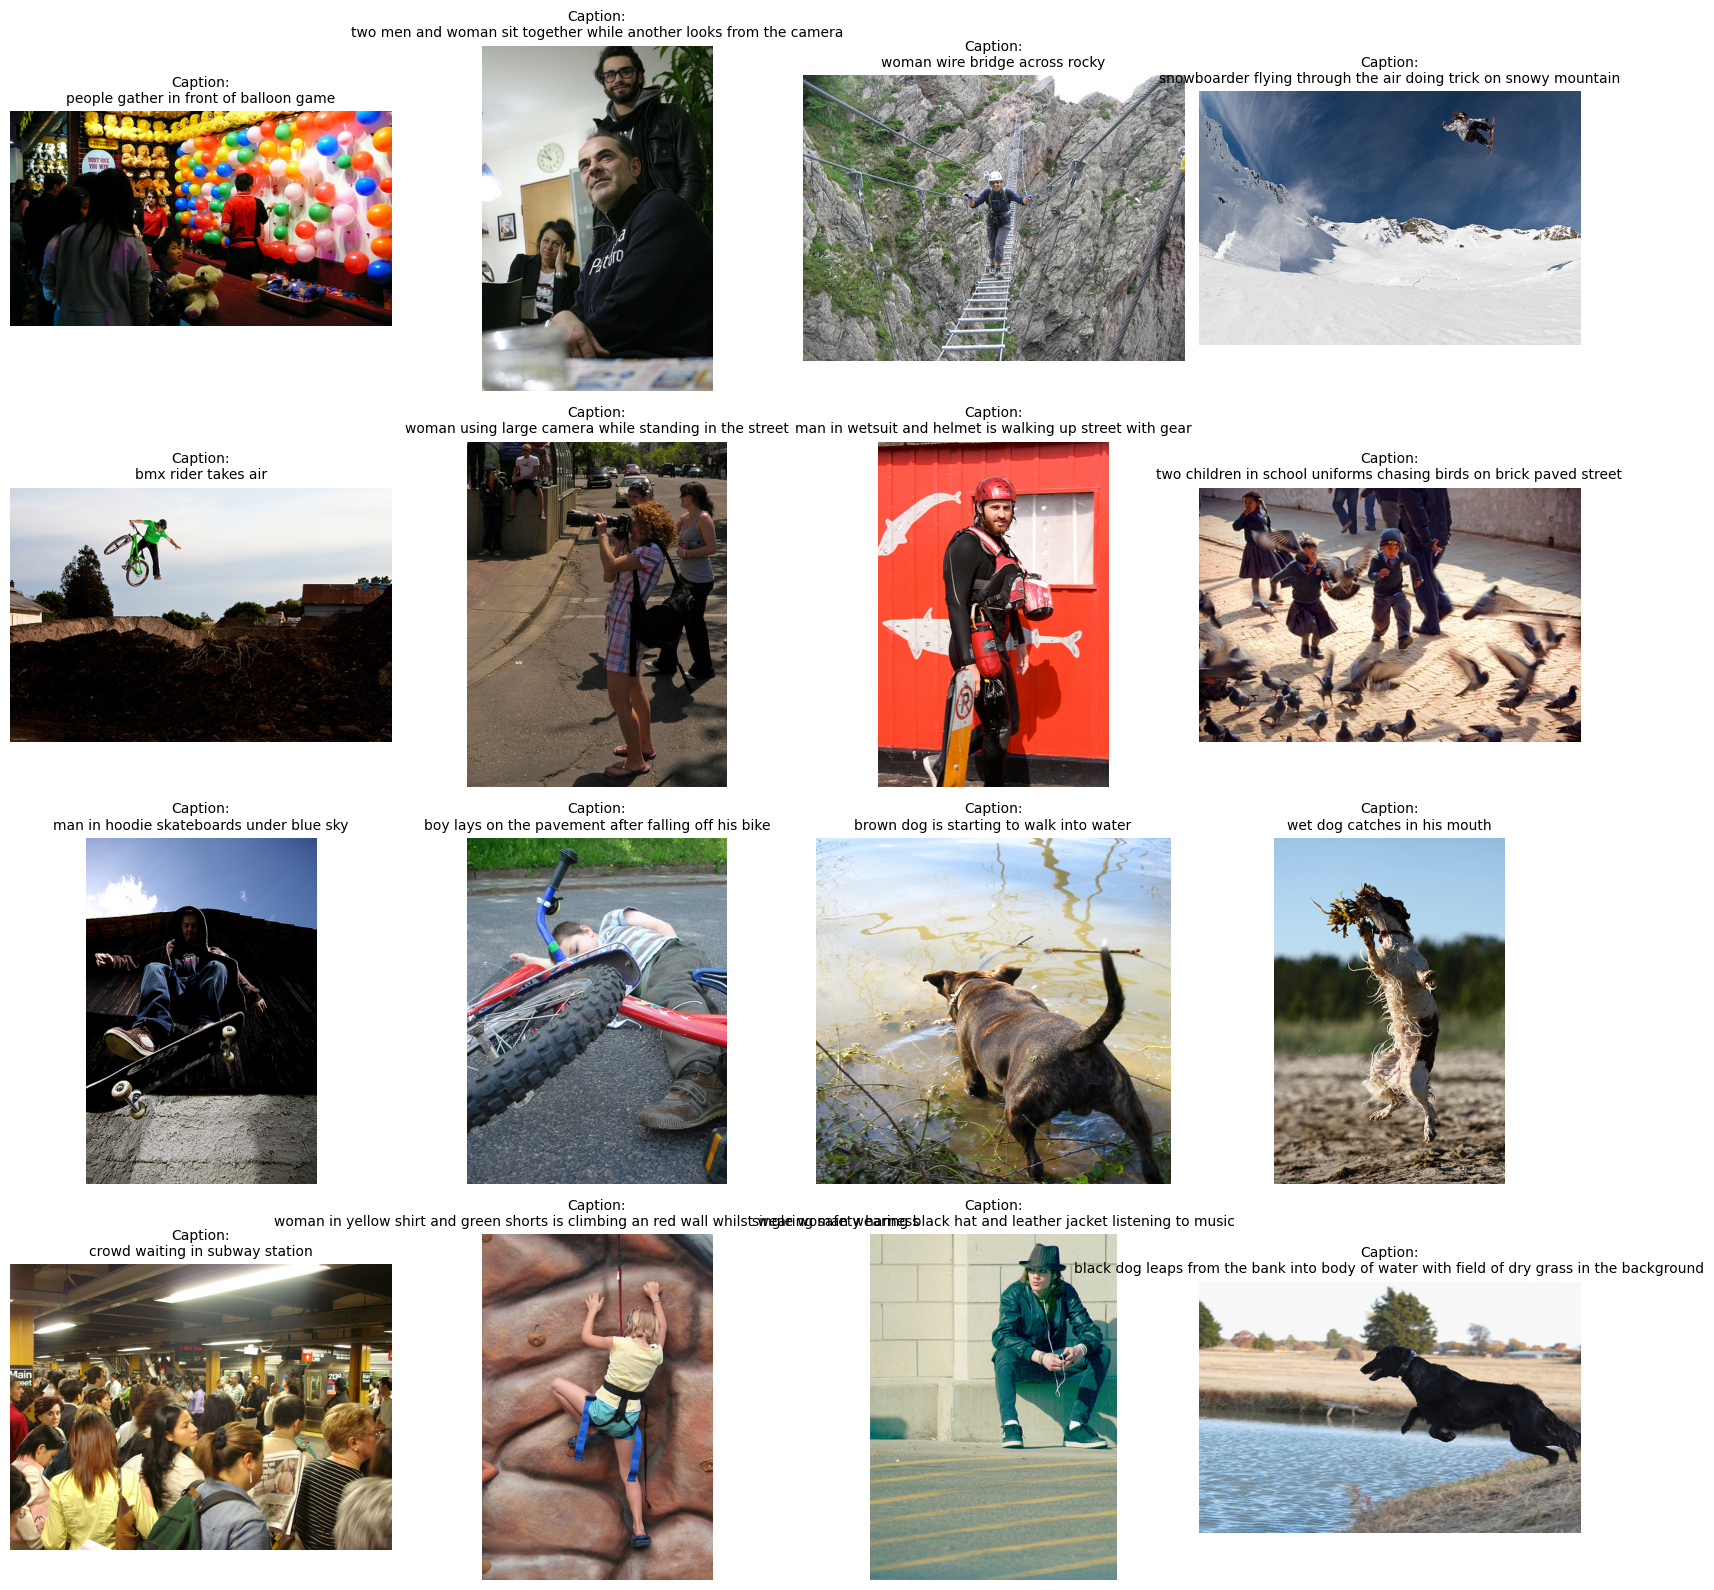

In [35]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception

# Load pre-trained Xception model for feature extraction
feature_model = Xception(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features from an image
def extract_image_feature(filename):
    image = load_img(filename, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = feature_model.predict(image, verbose=0)
    return feature

# Path to the images and test file
image_folder = '/kaggle/input/flickr8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset'
test_file = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'

# Read test image file names
with open(test_file, 'r') as file:
    image_names = file.read().strip().split('\n')

# Choose 16 random images
selected_images = random.sample(image_names, 16)

# Plot results in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Loop through selected images
for idx, image_name in enumerate(selected_images):
    image_path = os.path.join(image_folder, image_name)
    image_feature = extract_image_feature(image_path)
    image_feature = np.reshape(image_feature, (1, 2048))

    # Generate caption using the model
    caption = greedy_search(image_feature)

    # Display the image with its caption
    ax = axes[idx // 4, idx % 4]
    ax.imshow(load_img(image_path))
    ax.axis('off')
    ax.set_title(f"Caption:\n{caption}", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

# Download NLTK data
nltk.download('wordnet')

In [ ]:
# Load captions from Flickr8k.token.txt
def load_descriptions(file_path):
    descriptions = {}
    with open(file_path, 'r') as file:
        for line in file:
            img_id, caption = line.strip().split('\t')
            img_id = img_id.split('#')[0]  # Remove the #ID
            if img_id not in descriptions:
                descriptions[img_id] = []
            descriptions[img_id].append(caption.lower())
    return descriptions

# Load the descriptions
descriptions_file = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr8k.token.txt'
all_descriptions = load_descriptions(descriptions_file)
print(f"Loaded {len(all_descriptions)} image descriptions.")

In [ ]:
# Load test image IDs
def load_image_ids(file_path):
    with open(file_path, 'r') as file:
        return [line.strip().split('.')[0] for line in file]

test_images_file = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt'
test_image_ids = load_image_ids(test_images_file)
print(f"Loaded {len(test_image_ids)} test image IDs.")

In [ ]:
import os
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

def load_descriptions(file_path):
    descriptions = {}
    try:
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    key, caption = parts
                    descriptions[key] = caption
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    return descriptions

# Define evaluation function
def evaluate_model(model, image_ids, image_folder, descriptions, max_length):
    references, hypotheses = [], []
    meteor_scorer = Meteor()
    cider_scorer = Cider()

    print("Debug: Checking loaded descriptions...")
    for key in list(descriptions.keys())[:5]:
        print(f"Sample description key: {key}")

    for img_id in image_ids:
        # Ensure the description exists
        actual_captions = [descriptions.get(f"{img_id}.jpg#{i}", None) for i in range(5)]
        actual_captions = [cap for cap in actual_captions if cap]

        if not actual_captions:
            print(f"Warning: Missing description for {img_id}")
            continue

        # Extract image features
        image_path = os.path.join(image_folder, img_id + '.jpg')
        print(f"Processing image: {image_path}")
        image_feature = extract_image_feature(image_path)
        image_feature = np.reshape(image_feature, (1, 2048))

        # Generate caption
        generated_caption = greedy_search(image_feature)
        hypotheses.append(generated_caption.split())
        references.append([cap.split() for cap in actual_captions])

    # Compute BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=SmoothingFunction().method1)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=SmoothingFunction().method1)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method1)

    # ✅ Fix: Convert references & hypotheses to dict format (needed for METEOR & CIDEr)
    references_dict = {img_id: [' '.join(ref) for ref in refs] for img_id, refs in zip(image_ids, references)}
    hypotheses_dict = {img_id: [' '.join(hyp)] for img_id, hyp in zip(image_ids, hypotheses)}

    # Compute METEOR score
    meteor_score, _ = meteor_scorer.compute_score(references_dict, hypotheses_dict)

    # Compute CIDEr Score using the corrected `references_dict`
    cider_score, _ = cider_scorer.compute_score(references_dict, hypotheses_dict)
    clear_output(wait=False)
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")
    print(f"METEOR: {meteor_score:.4f}")
    print(f"CIDEr: {cider_score:.4f}")

In [ ]:
# Define the correct paths and variables
image_folder = '/kaggle/input/flickr8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset'  # Path to images
test_images_file = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt'  # Path to test image file
descriptions_file = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr8k.token.txt'  # Path to descriptions

# Load test image IDs
test_image_ids = load_image_ids(test_images_file)

# Load all descriptions
all_descriptions = load_descriptions(descriptions_file)

# Evaluate the model on test images
evaluate_model(model, test_image_ids, image_folder, all_descriptions, max_length)